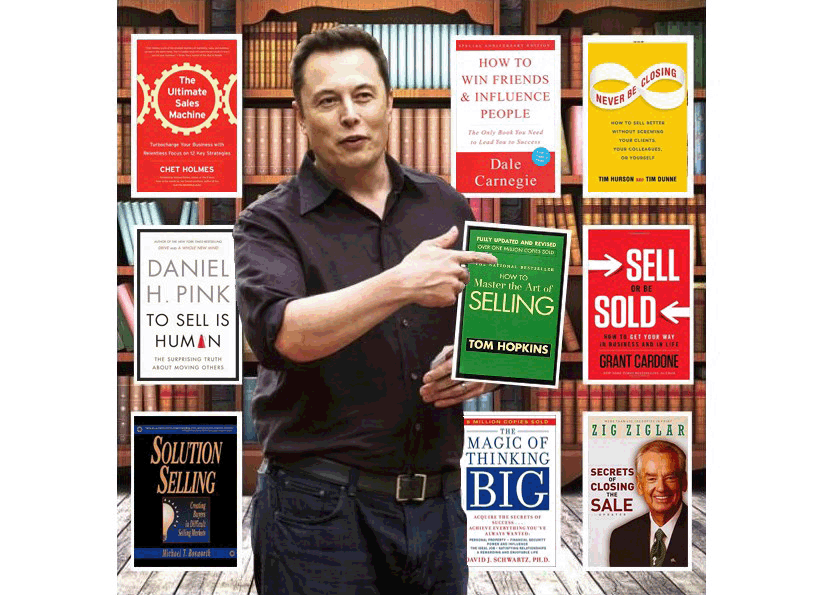

### Setup the environment

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Load Libraries and Data

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#Loading libraries
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import pairwise_distances
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import re
import seaborn as sns

In [ ]:
#Loading data
books = pd.read_csv("../input/books-dataset/books_data/books.csv", sep=";", 
                    error_bad_lines=False, encoding="latin-1")
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 
                 'imageUrlS', 'imageUrlM', 'imageUrlL']
users = pd.read_csv('../input/books-dataset/books_data/users.csv', sep=';', 
                    error_bad_lines=False, encoding="latin-1")
users.columns = ['userID', 'Location', 'Age']
ratings = pd.read_csv('../input/books-dataset/books_data/ratings.csv', sep=';', 
                      error_bad_lines=False, encoding="latin-1")
ratings.columns = ['userID', 'ISBN', 'bookRating']

### Check number of records and features given in each dataset
### Clean the data

In [ ]:
print(books.shape)
print(users.shape)
print(ratings.shape)

In [ ]:
books.head()

### We do not require the image links or URL so dropping them

In [ ]:
books.drop(['imageUrlS', 'imageUrlM', 'imageUrlL'],axis=1,inplace=True)

In [ ]:
books.head()

### Check unique values of year of publication

In [ ]:
books.yearOfPublication.unique()

### As it can be seen from above that there are some incorrect entries in this field. It looks like Publisher names 'DK Publishing Inc' and 'Gallimard' have been incorrectly loaded as yearOfPublication in dataset due to some errors in csv file.

### Also some of the entries are strings and same years have been entered as numbers in some places, some are future dates like 2030 etc

In [ ]:
books.loc[books.yearOfPublication == 'DK Publishing Inc',:]

In [ ]:
books.loc[books.yearOfPublication == 'Gallimard',:]

### Since we do not have year of publication anywhere in the entire row for DK Publishing Inc and Gallimard, we will drop these rows from the original dataset

In [ ]:
books = books[(books.yearOfPublication != 'DK Publishing Inc')
              & (books.yearOfPublication != 'Gallimard')]

### Change the datatype of year of publication as integer and drop rows having publisher value as null

In [ ]:
books.yearOfPublication = books.yearOfPublication.astype('int32')
books.dtypes

In [ ]:
#Publisher
#drop NaNs in publisher column
books = books.dropna(subset=['publisher'])
books.publisher.isnull().sum()

 ### Explore Users dataset
* Get all unique values in ascending order for column Age 
* Values below 5 and above 90 do not make much sense for our book rating case...hence replace these by NaNs
* Replace null values in column Age with mean
* Change the datatype of Age to int

In [ ]:
#Users
users.shape
users.head()

In [ ]:
#Age
print(sorted(users.Age.unique()))

### Age column has some invalid entries like nan, 0 and very high values like 100 and above
### Values below 5 and above 90 do not make much sense for our book rating case...hence replacing these by NaNs

In [ ]:
users.loc[(users.Age > 90) | (users.Age < 5), 'Age'] = np.nan

In [ ]:
#Replace All null values with mean
#replacing NaNs with mean
users.Age = users.Age.fillna(users.Age.mean())

In [ ]:
#Change the datatype into int
#setting the data type as int
users.Age = users.Age.astype(np.int32)

In [ ]:
print(sorted(users.Age.unique()))

### Explore Ratings dataset
* Check the shape
* Ratings dataset should have books only which exist in our books dataset. Drop the remaining rows
* Ratings dataset should have ratings from users which exist in users dataset. Drop the remaining rows
* Consider only ratings from 1-10 and leave 0s in column bookRating
* Find out which rating has been given highest number of times

In [ ]:
#check the shape
ratings.shape

### Ratings dataset will have users * books number of records

In [ ]:
n_users = users.shape[0]
n_books = books.shape[0]
print(n_users * n_books)

In [ ]:
ratings.head(5)

### Subset ratings data to only those books which are present in our data

In [ ]:
ratings_new = ratings[ratings.ISBN.isin(books.ISBN)]

In [ ]:
ratings.shape

In [ ]:
ratings_new.shape

### We observe that a lot of records were dropped because the books were not present in our dataset

In [ ]:
ratings.bookRating.unique()

### For analysis purpose we remove ratings of zero as will not help in recommendation

In [ ]:
#Hence segragating implicit and explict ratings datasets
ratings_explicit = ratings_new[ratings_new.bookRating != 0]
ratings_implicit = ratings_new[ratings_new.bookRating == 0]

In [ ]:
#checking shapes
print(ratings_new.shape)
print(ratings_explicit.shape)
print(ratings_implicit.shape)

In [ ]:
#plotting count of bookRating
sns.countplot(data=ratings_explicit , x='bookRating')
plt.show();


### It can be seen that higher ratings are more common amongst users and rating 8 has been rated highest number of times

### Collaborative Filtering Based Recommendation Systems
#### For more accurate results only consider users who have rated atleast 100 books

In [ ]:
counts1 = ratings_explicit['userID'].value_counts()
# print(counts1)
ratings_explicit = ratings_explicit[ratings_explicit['userID'].isin(counts1[counts1 >= 100].index)]

In [ ]:
ratings_explicit.head()

In [ ]:
ratings_explicit.shape

### Generate matrix table from explicit ratings table

In [ ]:
ratings_matrix = ratings_explicit.pivot(index='userID', columns='ISBN', values='bookRating').fillna(0)
userID = ratings_matrix.index
ISBN = ratings_matrix.columns
print(ratings_matrix.shape)
ratings_matrix.head()

### Since NaNs cannot be handled by training algorithm, replacing these by 0, which indicates absence of ratings

### Generate the predicted ratings using SVD with number of singular values to be 50

In [ ]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(ratings_matrix, k = 50)

In [ ]:
sigma = np.diag(sigma)
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = ratings_matrix.columns)

In [ ]:
preds_df.head()

### Take a particular user_id
* Lets find the recommendations for user with id 2110
* Get the predicted ratings for userID 2110 and sort them in descending order
* Create a dataframe with name user_data containing userID 2110 explicitly interacted books
* Combine the user_data and and corresponding book data(book_data) in a single dataframe with name user_full_info

In [ ]:
user_id = 2

In [ ]:
userID = ratings_matrix.iloc[user_id-1, :].name
userID

In [ ]:
preds_df.shape

In [ ]:
sorted_user_predictions = preds_df.iloc[user_id].sort_values(ascending=False)

In [ ]:
len(sorted_user_predictions)

In [ ]:
# Get all user interacted books
user_data = ratings_explicit[ratings_explicit.userID == (userID)]

In [ ]:
user_data.head()

In [ ]:
user_data.shape

In [ ]:
book_data = books[books.ISBN.isin(user_data.ISBN)]

In [ ]:
book_data.shape

In [ ]:
book_data.head()

In [ ]:
user_full_info = user_data.merge(book_data)

In [ ]:
user_full_info.head()

In [ ]:
print ('User {0} has already rated {1} books.'.format(userID, user_full_info.shape[0]))

In [ ]:
recommendations = (books[~books['ISBN'].isin(user_full_info['ISBN'])].
                   merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left', left_on = 'ISBN'
                         ,right_on = 'ISBN')).rename(columns = {user_id: 'Predictions'})

In [ ]:
recommendations.shape

In [ ]:
recommendations.head()

### Get top 10 recommendation for above given userID

In [ ]:
recommendations.sort_values('Predictions', ascending = False).iloc[:10, :]